# Predicting online shoppers’ purchasing intention
## Classification using SHAP for feature interpretation and selection
Models tested
* Logistic Regression
* Decision Tree
* Random Forest
* Extra Trees
* AdaBoost
* Gradient Boosting
* XGBoost

**Goal: Understand model predictions and improve model performance using SHAPley values to subset features by importance**

---

Data source:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

SHAP:
https://shap.readthedocs.io/en/latest/index.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pprint
import warnings
from collections import Counter

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
from imblearn.over_sampling import SMOTE  # try for imbalanced classes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

## import custom function to get feature names
from helper import get_feature_names

# datasets to test
# from sklearn.datasets import load_iris
# from sklearn.datasets import make_moons, make_circles, make_classification

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, classification_report

import shap
shap.initjs()

In [2]:
## Load cleaned data arrays
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13972, 29) (6872, 29) (13972,) (6872,)


In [3]:
feature_names2 = ['numerical__Administrative',
 'numerical__Administrative_Duration',
 'numerical__Informational',
 'numerical__Informational_Duration',
 'numerical__ProductRelated',
 'numerical__ProductRelated_Duration',
 'numerical__BounceRates',
 'numerical__ExitRates',
 'numerical__PageValues',
 'numerical__SpecialDay',
 'numerical__OperatingSystems',
 'numerical__Browser',
 'numerical__Region',
 'numerical__TrafficType',
 'categorical__x0_Aug',
 'categorical__x0_Dec',
 'categorical__x0_Feb',
 'categorical__x0_Jul',
 'categorical__x0_June',
 'categorical__x0_Mar',
 'categorical__x0_May',
 'categorical__x0_Nov',
 'categorical__x0_Oct',
 'categorical__x0_Sep',
 'categorical__x1_New_Visitor',
 'categorical__x1_Other',
 'categorical__x1_Returning_Visitor',
 'categorical__x2_False',
 'categorical__x2_True']

In [4]:
X_train = pd.DataFrame(X_train, columns=feature_names2)
X_test = pd.DataFrame(X_test, columns=feature_names2)
X_train.drop('categorical__x2_False', axis=1, inplace=True)
X_test.drop('categorical__x2_False', axis=1, inplace=True)

# Tuning Hyperparameters

In [5]:
model = GradientBoostingClassifier()
# what possible params to tune
pprint.pprint(model.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [6]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "learning_rate": [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_depth": [4, 6, 8, None],
}


# Random search of parameters, using cross validation, use all cores
model_rand = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1,
)

In [7]:
# Fit the random search model
model_rand.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [4, 6, 8, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400,
                                                         1600]},
                   random_state=0, verbose=2)

In [8]:
# print results of rand grid search
best_params = model_rand.best_params_
best_params

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'learning_rate': 0.1}

In [9]:
## Model new (optimized from results of grid search)
model_best = GradientBoostingClassifier(**best_params)

model_best.fit(X_train,y_train)  # fit the model to the training data

GradientBoostingClassifier(max_depth=None, max_features='auto',
                           min_samples_leaf=2, n_estimators=400)

In [10]:
## Get CV score
score = cross_val_score(model_best, X_train, y_train)
print(np.round(score.mean(), 4))

0.9236


In [11]:
## Calc Prec, Recall, F1 scores on test set
y_pred = model_best.predict(X_test)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report1 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report1)
report1_df = pd.DataFrame(report1).transpose()
model_name = str(model).strip('()')
report1_df.to_csv(f"{model_name}_report1.csv", index=False)

{'0: No Revenue': {'precision': 0.9123202706512545, 'recall': 0.9417927823050058, 'f1-score': 0.9268222826865244, 'support': 3436}, '1: Revenue': {'precision': 0.9398496240601504, 'recall': 0.909487776484284, 'f1-score': 0.9244194645762461, 'support': 3436}, 'accuracy': 0.9256402793946449, 'macro avg': {'precision': 0.9260849473557025, 'recall': 0.925640279394645, 'f1-score': 0.9256208736313853, 'support': 6872}, 'weighted avg': {'precision': 0.9260849473557025, 'recall': 0.9256402793946449, 'f1-score': 0.9256208736313853, 'support': 6872}}


In [12]:
roc_auc_score(y_test, model_best.predict_proba(X_test)[:,1])

0.9797617688353544

## SHAP visuals 

To show feature contributions to the model output (magnitude, postiive or negative class, num of samples, ...)


Types of plots
* Force Plot
* Bar Plot
* Beeswarm Plot / Scatter Plot
* Waterfall Plot (for indiv preds)

In [13]:
## Take smaller samples for visualization
X_train_sample = shap.utils.sample(X_train, nsamples=50, random_state=0)
X_test_sample = shap.utils.sample(X_test, nsamples=50, random_state=0)

## Kernel Explainer

In [14]:
# explain predictions of model on test set
explainer = shap.KernelExplainer(model_best.predict_proba, X_train_sample)

# compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
# Force Plot
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

Force plot:
    
* The horizontal/X-axis at the top represents the sample number. We have 100 samples in this visual.
* The two colors represent the two class labels (default or no default)

## Tree Explainer

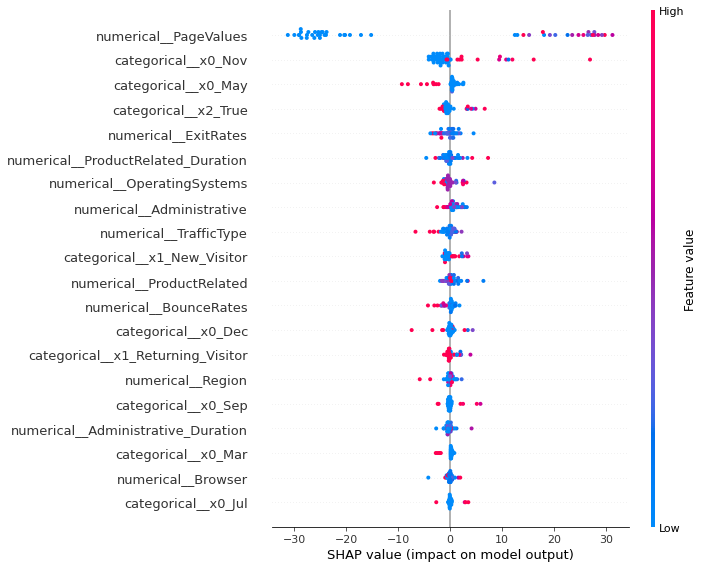

In [16]:
## Bar Plot 
# explain all the predictions in the test set
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values, (X_test_sample))

Bar Plot:

creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

In [17]:
# # index [1] represents class label 1
# shap.summary_plot(shap_values[1], X_train_sample)

In [18]:
# # Waterfall plot
# # ## Designed for INDIVIDUAL preds
# # shap.plots.waterfall(shap_values[0])
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_train_sample.iloc[0])

shap_values is a list of 2 arrays, representing class labels 0 and 1.

Both arrays have 50 observations and 29 features.

## Get the most and least important features

In [19]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
top_inds.shape
print(top_inds)

[ 8 21 20 27  7  5 10  0 13 24  4  6 15 26 12 23  1 19 11 17 22 16  3  2
 14 18  9 25]


In [20]:
# get feature indices for top 20, combine them all together 1 list
# f_indices = list(top_inds[:, :20].flatten())
# f_indices = list(top_inds)
# count occurences, get top 20 most important features
# c = Counter(top_inds)

# to_keep = []
# # at least this many rows need to have a feature X in its top 20
# # HIGHER = stricter limit
# min_count = 20


# for idx, count in c.items():
# #     print(idx, count)
#     if count >= min_count:
#         to_keep.append(idx)

In [21]:
# print(len(to_keep))  ## keep this many features
# print(to_keep)  ## column indicies of features to keep

In [22]:
to_keep = top_inds[:20]

## New Model from Subset of Features

In [23]:
## Subset of training data using top N most important features from SHAP
X_train_ss = X_train.iloc[:,to_keep]
X_train_ss.shape

(13972, 20)

In [24]:
# specify parameters and distributions to sample from
## use same param_dist as before

# Random search of parameters, using cross validation, use all cores
model_rand = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, random_state=0, n_jobs=-1)

model_rand.fit(X_train_ss, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [4, 6, 8, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400,
                                                         1600]},
                   random_state=0, verbose=2)

In [25]:
# print results of rand grid search
best_params2 = model_rand.best_params_
pprint.pprint(best_params2)

{'learning_rate': 0.001,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1600}


In [26]:
model_best = GradientBoostingClassifier(**best_params2)
model_best.fit(X_train_ss, y_train)  # fit the model to the training data

GradientBoostingClassifier(learning_rate=0.001, max_depth=None,
                           max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=10, n_estimators=1600)

In [27]:
model_old = GradientBoostingClassifier(**best_params)
model_old.fit(X_train_ss, y_train)  # fit the model to the training data

GradientBoostingClassifier(max_depth=None, max_features='auto',
                           min_samples_leaf=2, n_estimators=400)

In [28]:
## Get CV score
score = cross_val_score(model_best, X_train_ss, y_train)
print(np.round(score.mean(), 4))

## with old hps
score2 = cross_val_score(model_old, X_train_ss, y_train)
print(np.round(score2.mean(), 4))

0.9235
0.9214


model with new hps performed better

In [29]:
## Calc Prec, Recall, F1 scores on test set
X_test_ss = X_test.iloc[:,to_keep]

y_pred = model_best.predict(X_test_ss)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report2 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report2)
report2_df = pd.DataFrame(report2).transpose()
model_name = str(model).strip('()')
report2_df.to_csv(f"{model_name}_report2.csv", index=False)

{'0: No Revenue': {'precision': 0.9232743867655447, 'recall': 0.9420838183934808, 'f1-score': 0.9325842696629214, 'support': 3436}, '1: Revenue': {'precision': 0.9408793820558526, 'recall': 0.9217112922002328, 'f1-score': 0.9311967068509261, 'support': 3436}, 'accuracy': 0.9318975552968568, 'macro avg': {'precision': 0.9320768844106987, 'recall': 0.9318975552968568, 'f1-score': 0.9318904882569238, 'support': 6872}, 'weighted avg': {'precision': 0.9320768844106987, 'recall': 0.9318975552968568, 'f1-score': 0.9318904882569238, 'support': 6872}}


Report1 is with full dataset. Report2 is with subset of features chosen by SHAP.

In [30]:
print(round(roc_auc_score(y_test, model_best.predict_proba(X_test_ss)[:,1]),4))

0.9828
